# 0. Setup

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data 
Dataset : 

In [2]:
train = pd.read_csv('data/sales_train.csv', parse_dates=['date'])
test = pd.read_csv('data/sales_test.csv')
calendar = pd.read_csv('data/calendar.csv', parse_dates=['date']).sort_values(by = ['warehouse','date'])
weights = pd.read_csv('data/test_weights.csv')
inventory = pd.read_csv('data/inventory.csv')

# 1. Examining individual tables

## 1.1. `calendar` table

Columns
| Column name | Data type |Description |
|:--------:|:----:|:---------|
| date | datetime64 | Date (Object in source data, but changed to datetime format) |
| holiday_name | object | name of public holiday if any |
| holiday | int64 | 0/1 indicating the presence of holidays |
| shops_closed | int64 | public holiday with most of the shops or large part of shops closed |
| winter_school_holidays | int64 | winter school holidays |
| school_holidays | int64 | school holidays |
| warehouse | object | warehouse name |
| dow | int64 | Day of week (added) |

In [3]:
# A brief look at the table
calendar.head()

date   holiday_name  holiday  shops_closed  \
17698 2016-01-01  New Years Day        1             1   
12672 2016-01-02            NaN        0             0   
12440 2016-01-03            NaN        0             0   
7344  2016-01-04            NaN        0             0   
11523 2016-01-05            NaN        0             0   

       winter_school_holidays  school_holidays warehouse  
17698                       0                0    Brno_1  
12672                       0                0    Brno_1  
12440                       0                0    Brno_1  
7344                        0                0    Brno_1  
11523                       0                0    Brno_1

In [4]:
# Check for missing values
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23016 entries, 17698 to 3915
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    23016 non-null  datetime64[ns]
 1   holiday_name            930 non-null    object        
 2   holiday                 23016 non-null  int64         
 3   shops_closed            23016 non-null  int64         
 4   winter_school_holidays  23016 non-null  int64         
 5   school_holidays         23016 non-null  int64         
 6   warehouse               23016 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 1.4+ MB


### Feature engineering from 'date' column

In [5]:
# Day of week column (0 Monday ~ 6 Sunday).
calendar['dow'] = calendar['date'].dt.dayofweek

# Weekend column
calendar['weekend'] = calendar['dow'].apply(lambda x : 1 if x==5 or x==6 else 0)

# Day of Year column
calendar['doy'] = calendar['date'].dt.dayofyear

In [6]:
# Convert dow and doy features to sine & cosine transformations, as they are cyclical

calendar['doy_sin'] = np.sin(2 * np.pi * calendar['doy'] / 365)
calendar['doy_cos'] = np.cos(2 * np.pi * calendar['doy'] / 365)

calendar['dow_sin'] = np.sin(2 * np.pi * calendar['dow'] / 7)
calendar['dow_cos'] = np.cos(2 * np.pi * calendar['dow'] / 7)

### A closer look at school holidays

In [7]:
# Identify warehouses with valid school_holidays data
calendar.loc[(calendar['school_holidays'] == 1)].warehouse.value_counts()

Munich_1       82
Frankfurt_1    71
Name: warehouse, dtype: int64

> Strangely enough, school holiday data for warehouses other than the German ones are not available. Could consider dropping school holiday columns altogether as there are no precise information on school holidays in czechia and hungary

### Fill in holiday names

In [8]:
# Identify holidays with missing name
calendar.loc[(calendar.holiday == 1) & calendar.holiday_name.isna(),'date'].value_counts()

2016-03-25    7
2016-03-26    7
2024-03-30    7
2023-04-09    7
2023-04-08    7
2022-04-17    7
2021-04-04    7
2021-04-03    7
2020-04-12    7
2020-04-11    7
2019-04-21    7
2019-04-20    7
2018-04-02    7
2018-04-01    7
2018-03-31    7
2018-03-30    7
2017-04-17    7
2017-04-15    7
2017-04-14    7
2016-03-28    7
2016-03-27    7
2024-03-31    7
2017-04-16    6
2022-04-16    6
Name: date, dtype: int64

> Most of the holidays with missing name are dates around Easter, with most being "Holy Saturday" (Silent day) and "Easter Sunday"

In [ ]:
# Insert holiday names
import datetime as dt

holiday_dict = {
    '2016-03-25': 'Good Friday',
    '2016-03-26': 'Holy Saturday',
    '2016-03-27': 'Easter Sunday',
    '2016-03-28': 'Easter Monday',
    '2017-04-14': 'Good Friday',
    '2017-04-15': 'Holy Saturday',
    '2017-04-16': 'Easter Sunday',
    '2017-04-17': 'Easter Monday',
    '2018-03-30': 'Good Friday',
    '2018-03-31': 'Holy Saturday',
    '2018-04-01': 'Easter Sunday',
    '2018-04-02': 'Easter Monday',
    '2019-04-20': 'Holy Saturday',
    '2019-04-21': 'Easter Sunday',
    '2020-04-11': 'Holy Saturday',
    '2020-04-12': 'Easter Sunday',
    '2021-04-03': 'Holy Saturday',
    '2021-04-04': 'Easter Sunday',
    '2022-04-16': 'Holy Saturday',
    '2022-04-17': 'Easter Sunday',
    '2023-04-08': 'Holy Saturday',
    '2023-04-09': 'Easter Sunday',
    '2024-03-30': 'Holy Saturday',
    '2024-03-31': 'Easter Sunday'
}

for k, v in holiday_dict.items():
    calendar.loc[calendar['date'] == dt.datetime.strptime(k, '%Y-%m-%d'), 'holiday_name'] = v

# Verify
print(f"There remains {calendar.loc[(calendar.holiday == 1) & calendar.holiday_name.isna(),'date'].count()} holidays without recorded name")

There remains 0 holidays without recorded name


### Categorize holidays
Holidays can be grouped into "religious" holidays and "general" holidays

In [ ]:
# Create category column

holiday_categories = {
    "New Years Day": "general",
    "2nd Christmas Day": "religious",
    "1st Christmas Day": "religious",
    "International Women's Day": "general",
    "Christmas Eve": "religious",
    "Good Friday": "religious",
    "Holy Saturday": "religious",
    "Easter Sunday": "religious",
    "Easter Monday": "religious",
    "Labour Day": "general",
    "Jan Hus": "general",
    "Den boje za svobodu a demokracii": "general",
    "Den vzniku samostatneho ceskoslovenskeho statu": "general",
    "Den ceske statnosti": "general",
    "Cyrila a Metodej": "religious",
    "Den osvobozeni": "general",
    "Whit Monday": "religious",
    "Whit Sunday": "religious",
    "German Unity Day": "general",
    "Corpus Christi": "religious",
    "All Saints Day": "religious",
    "Ascension Day": "religious",
    "Memorial Day for the Victims of the Holocaust": "general",
    "Independent Hungary Day": "general",
    "Epiphany": "religious",
    "Memorial Day of the Republic": "general",
    "Assumption of the Virgin Mary": "religious",
    "State Foundation Day": "general",
    "Memorial Day for the Victims of the Communist Dictatorships": "general",
    "Memorial Day for the Martyrs of Arad": "general",
    "Memorial Day of the 1956 Revolution": "general",
    "Reformation Day": "religious",
    "National Defense Day": "general",
    "Day of National Unity": "general",
    "Peace Festival in Augsburg": "general",
    "Hungary National Day Holiday": "general",
    "Christmas Holiday": "religious",
    "1848 Revolution Memorial Day (Extra holiday)": "general",
    "All Saints' Day Holiday": "religious"
}

for key, val in holiday_categories.items():
    calendar.loc[calendar['holiday_name'] == key,'holiday_cat'] = val
calendar.holiday_cat.value_counts()

religious    542
general      410
Name: holiday_cat, dtype: int64

In [ ]:
# Check to see if shops closed in days that are not holidays
calendar.loc[(calendar['shops_closed'] == 1) & (calendar['holiday'] == 0)]

Empty DataFrame
Columns: [date, holiday_name, holiday, shops_closed, winter_school_holidays, school_holidays, warehouse, dow, weekend, doy, doy_sin, doy_cos, dow_sin, dow_cos, holiday_cat]
Index: []

### Count consecutive holidays
Check for consecutive holidays to identify "long" holidays which can also have impact on sales

In [12]:
import numpy as np
calendar.sort_values(by=['warehouse','date'], inplace=True)

g = calendar['holiday'].ne(calendar['holiday'].shift()).cumsum()

calendar['consecutive_holidays'] = calendar.groupby(g)['holiday'].transform('size') * np.where(calendar['holiday'], 1, 0)

calendar.tail(30)

date       holiday_name  holiday  shops_closed  \
11536 2024-12-02                NaN        0             0   
1438  2024-12-03                NaN        0             0   
3774  2024-12-04                NaN        0             0   
3778  2024-12-05                NaN        0             0   
18515 2024-12-06                NaN        0             0   
8173  2024-12-07                NaN        0             0   
12963 2024-12-08                NaN        0             0   
5650  2024-12-09                NaN        0             0   
14843 2024-12-10                NaN        0             0   
4159  2024-12-11                NaN        0             0   
4168  2024-12-12                NaN        0             0   
21994 2024-12-13                NaN        0             0   
6902  2024-12-14                NaN        0             0   
14844 2024-12-15                NaN        0             0   
19972 2024-12-16                NaN        0             0   
1023  2024-12-17                NaN        0             0   
21219 2024-12-18                NaN        0             0   
6486  2024-12-19                NaN        0             0   
22326 2024-12-20                NaN        0             0   
2261  2024-12-21                NaN        0             0   
12485 2024-12-22                NaN        0             0   
4806  2024-12-23                NaN        0             0   
22575 2024-12-24      Christmas Eve        1             0   
12552 2024-12-25  1st Christmas Day        1             1   
12426 2024-12-26  2nd Christmas Day        1             1   
7476  2024-12-27                NaN        0             0   
4655  2024-12-28                NaN        0             0   
22168 2024-12-29                NaN        0             0   
12542 2024-12-30                NaN        0             0   
3915  2024-12-31                NaN        0             0   

       winter_school_holidays  school_holidays warehouse  dow  weekend  doy  \
11536                       0                0  Prague_3    0        0  337   
1438                        0                0  Prague_3    1        0  338   
3774                        0                0  Prague_3    2        0  339   
3778                        0                0  Prague_3    3        0  340   
18515                       0                0  Prague_3    4        0  341   
8173                        0                0  Prague_3    5        1  342   
12963                       0                0  Prague_3    6        1  343   
5650                        0                0  Prague_3    0        0  344   
14843                       0                0  Prague_3    1        0  345   
4159                        0                0  Prague_3    2        0  346   
4168                        0                0  Prague_3    3        0  347   
21994                       0                0  Prague_3    4        0  348   
6902                        0                0  Prague_3    5        1  349   
14844                       0                0  Prague_3    6        1  350   
19972                       0                0  Prague_3    0        0  351   
1023                        0                0  Prague_3    1        0  352   
21219                       0                0  Prague_3    2        0  353   
6486                        0                0  Prague_3    3        0  354   
22326                       0                0  Prague_3    4        0  355   
2261                        0                0  Prague_3    5        1  356   
12485                       0                0  Prague_3    6        1  357   
4806                        0                0  Prague_3    0        0  358   
22575                       0                0  Prague_3    1        0  359   
12552                       0                0  Prague_3    2        0  360   
12426                       0                0  Prague_3    3        0  361   
7476                        0      

## 1.2. `sales_train` table 
Columns
| Column name | Data type |Description |
|:--------:|:----:|:---------|
| unique_id | int64 |Inventory id (unique) |
| date | datetime64  | Date (Object in source data, but changed to datetime format) |
| warehouse | float64 | Name of warehouse : 'Budapest_1', 'Frankfurt_1', 'Munich_1', 'Prague_1', 'Prague_3','Prague_2', 'Brno_1' |
| total_orders | float64 | Historical orders for the selected warehouse |
| sales | float64 | Sales volumne (Target value) | 
| sell_price_main | float64 | Sell price |
| availability | float64 | Proportion of the inventory day available to customers in a given date |
| type_x_discount (0-6) | float64 | Percentage of discount for each promotion. Negative discount value to be interpreted as no discount. | 

In [ ]:
# A brief look at the table
print(train.shape)
train.head()

(4007419, 14)


unique_id       date   warehouse  total_orders  sales  sell_price_main  \
0       4845 2024-03-10  Budapest_1        6436.0  16.34           646.26   
1       4845 2021-05-25  Budapest_1        4663.0  12.63           455.96   
2       4845 2021-12-20  Budapest_1        6507.0  34.55           455.96   
3       4845 2023-04-29  Budapest_1        5463.0  34.52           646.26   
4       4845 2022-04-01  Budapest_1        5997.0  35.92           486.41   

   availability  type_0_discount  type_1_discount  type_2_discount  \
0          1.00          0.00000              0.0              0.0   
1          1.00          0.00000              0.0              0.0   
2          1.00          0.00000              0.0              0.0   
3          0.96          0.20024              0.0              0.0   
4          1.00          0.00000              0.0              0.0   

   type_3_discount  type_4_discount  type_5_discount  type_6_discount  
0              0.0          0.15312              0.0              0.0  
1              0.0          0.15025              0.0              0.0  
2              0.0          0.15025              0.0              0.0  
3              0.0          0.15312              0.0              0.0  
4              0.0          0.15649              0.0              0.0

In [14]:
train.describe()

unique_id  total_orders         sales  sell_price_main  \
count  4.007419e+06  4.007367e+06  4.007367e+06     4.007419e+06   
mean   2.740801e+03  5.995722e+03  1.083808e+02     1.814199e+02   
std    1.558566e+03  2.479598e+03  3.603327e+02     4.611014e+02   
min    0.000000e+00  4.580000e+02  0.000000e+00     2.000000e-02   
25%    1.398000e+03  4.402000e+03  1.798000e+01     2.113000e+01   
50%    2.744000e+03  5.515000e+03  3.952000e+01     4.564000e+01   
75%    4.084000e+03  8.011000e+03  9.447000e+01     1.121300e+02   
max    5.431000e+03  1.847500e+04  2.631619e+04     2.168299e+04   

       availability  type_0_discount  type_1_discount  type_2_discount  \
count  4.007419e+06     4.007419e+06     4.007419e+06     4.007419e+06   
mean   9.253107e-01     8.518626e-03     1.240899e-04     1.163193e-03   
std    1.796205e-01     5.147027e-02     5.142815e-03     1.879977e-02   
min    1.000000e-02    -2.094930e+01     0.000000e+00     0.000000e+00   
25%    1.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00   
50%    1.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00   
75%    1.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00   
max    1.000000e+00     9.916400e-01     5.000000e-01     7.637200e-01   

       type_3_discount  type_4_discount  type_5_discount  type_6_discount  
count     4.007419e+06     4.007419e+06     4.007419e+06     4.007419e+06  
mean      5.452819e-06     5.680178e-03     4.049705e-04     1.045480e-02  
std       8.922436e-04     2.892965e-02     9.199913e-03     5.545035e-02  
min       0.000000e+00    -4.712000e-02     0.000000e+00    -8.014900e-01  
25%       0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00  
50%       0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00  
75%       0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00  
max       2.506300e-01     4.529000e-01     6.691400e-01     9.000500e-01

In [15]:
# Check for duplicated data
print(f'Duplicate data : {train.duplicated().sum()}')

Duplicate data : 0


In [16]:
# Check for missing values
train.isna().sum()

unique_id           0
date                0
warehouse           0
total_orders       52
sales              52
sell_price_main     0
availability        0
type_0_discount     0
type_1_discount     0
type_2_discount     0
type_3_discount     0
type_4_discount     0
type_5_discount     0
type_6_discount     0
dtype: int64

In [17]:
# Verify whether a product is handled in one warehouse

print(f"""Number of product ids : {len(train.unique_id.unique())} : {train.unique_id.min()} (min) ~ {train.unique_id.max()} (max)
      \nNumber of absent prouct ids : {train.unique_id.max()-len(train.unique_id.unique())}""")

missing_ids= list(set(list(np.arange(0,5431)))-set(train.unique_id.unique()))

Number of product ids : 5390 : 0 (min) ~ 5431 (max)
      
Number of absent prouct ids : 41


In [18]:
print(f"Total number of product ids of warehouses : {train.groupby('warehouse').agg(count = ('unique_id','nunique'))['count'].sum()}")
train.groupby('warehouse').agg(count = ('unique_id','nunique'))

Total number of product ids of warehouses : 5390


count
warehouse         
Brno_1         757
Budapest_1     940
Frankfurt_1    483
Munich_1       640
Prague_1       857
Prague_2       853
Prague_3       860

> All products belong in one of the warehouses

### Overview of sales and order data

In [19]:
train_group = train.groupby(['warehouse','date'], as_index = False).agg(order_sum = ('total_orders','sum'), sales_sum = ('sales','sum'))
train_group['sales_per_order'] = train_group['sales_sum'] / train_group['order_sum']
train_group

warehouse       date  order_sum  sales_sum  sales_per_order
0       Brno_1 2020-08-01  1690149.0   48027.55         0.028416
1       Brno_1 2020-08-02  1687383.0   44969.77         0.026651
2       Brno_1 2020-08-03  1937441.0   54473.14         0.028116
3       Brno_1 2020-08-04  1820225.0   48647.92         0.026726
4       Brno_1 2020-08-05  1761617.0   47563.47         0.027000
...        ...        ...        ...        ...              ...
8962  Prague_3 2024-05-29  3215790.0   44732.75         0.013910
8963  Prague_3 2024-05-30  3685668.0   53670.85         0.014562
8964  Prague_3 2024-05-31  4038001.0   62156.54         0.015393
8965  Prague_3 2024-06-01  3393855.0   50633.23         0.014919
8966  Prague_3 2024-06-02  3247846.0   48659.02         0.014982

[8967 rows x 5 columns]

In [20]:
# Total orders per warehouse
import plotly.express as px
fig = px.line(train_group, x='date', y='order_sum', color='warehouse')
fig.show()

> There seem to be yearly seasonality, with sharp incline and then decline at the beginning of each year

In [ ]:
train_group.loc[train_group.date  == '2021-09-30']

warehouse       date  order_sum  sales_sum  sales_per_order
425       Brno_1 2021-09-30  3615244.0   78016.93         0.021580
1827  Budapest_1 2021-09-30  1867131.0   39784.55         0.021308
3784    Munich_1 2021-09-30   160000.0    6266.02         0.039163
5186    Prague_1 2021-09-30  4567904.0   78515.08         0.017188
6588    Prague_2 2021-09-30  2396505.0   41778.06         0.017433
7990    Prague_3 2021-09-30  2361472.0   40789.05         0.017273

In [22]:
# Total orders per warehouse
import plotly.express as px
fig = px.line(train_group, x='date', y='sales_per_order', color='warehouse')
fig.show()

> Besides the outlier peak of Munich_1 warehouse around July 2021 at the beginning of the operation, Total orders per warehouse seems to be stable, showing seasonality 

In [23]:
import seaborn as sns
# Zooming in on Munich
wh_m1 = train.loc[train['warehouse'] == 'Munich_1']
wh_m1.head()
wh_m1_pivot = pd.pivot_table(wh_m1, values = 'total_orders', index = 'date', columns = 'unique_id')

wh_m1_pivot

unique_id     2     6       7     17      28    31      65      82    87    \
date                                                                         
2021-05-20     NaN   NaN     NaN   NaN     NaN   NaN     NaN     NaN   NaN   
2021-05-25     NaN   NaN   478.0   NaN     NaN   NaN     NaN     NaN   NaN   
2021-05-26     NaN   NaN     NaN   NaN     NaN   NaN     NaN     NaN   NaN   
2021-05-27     NaN   NaN     NaN   NaN     NaN   NaN     NaN     NaN   NaN   
2021-05-28     NaN   NaN     NaN   NaN     NaN   NaN     NaN     NaN   NaN   
...            ...   ...     ...   ...     ...   ...     ...     ...   ...   
2024-05-29  4754.0   NaN  4754.0   NaN  4754.0   NaN  4754.0  4754.0   NaN   
2024-05-30  3315.0   NaN  3315.0   NaN  3315.0   NaN  3315.0  3315.0   NaN   
2024-05-31  6517.0   NaN  6517.0   NaN  6517.0   NaN  6517.0  6517.0   NaN   
2024-06-01  3920.0   NaN  3920.0   NaN  3920.0   NaN  3920.0  3920.0   NaN   
2024-06-02  2962.0   NaN  2962.0   NaN  2962.0   NaN  2962.0  2962.0   NaN   

unique_id   93    ...    5319    5341    5344    5345  5356  5357  5359  5387  \
date              ...                                                           
2021-05-20   NaN  ...     NaN     NaN     NaN     NaN   NaN   NaN   NaN   NaN   
2021-05-25   NaN  ...     NaN     NaN     NaN     NaN   NaN   NaN   NaN   NaN   
2021-05-26   NaN  ...     NaN     NaN     NaN     NaN   NaN   NaN   NaN   NaN   
2021-05-27   NaN  ...     NaN     NaN     NaN     NaN   NaN   NaN   NaN   NaN   
2021-05-28   NaN  ...     NaN     NaN     NaN     NaN   NaN   NaN   NaN   NaN   
...          ...  ...     ...     ...     ...     ...   ...   ...   ...   ...   
2024-05-29   NaN  ...  4754.0  4754.0  4754.0  4754.0   NaN   NaN   NaN   NaN   
2024-05-30   NaN  ...  3315.0  3315.0  3315.0  3315.0   NaN   NaN   NaN   NaN   
2024-05-31   NaN  ...  6517.0  6517.0  6517.0  6517.0   NaN   NaN   NaN   NaN   
2024-06-01   NaN  ...  3920.0  3920.0  3920.0  3920.0   NaN   NaN   NaN   NaN   
2024-06-02   NaN  ...  2962.0  2962.0  2962.0  2962.0   NaN   NaN   NaN   NaN   

unique_id     5399    5425  
date                        
2021-05-20     NaN     NaN  
2021-05-25     NaN     NaN  
2021-05-26     NaN     NaN  
2021-05-27     NaN     NaN  
2021-05-28     NaN     NaN  
...            ...     ...  
2024-05-29  4754.0  4754.0  
2024-05-30  3315.0  3315.0  
2024-05-31  6517.0  6517.0  
2024-06-01     NaN  3920.0  
2024-06-02  2962.0  2962.0  

[1087 rows x 640 columns]

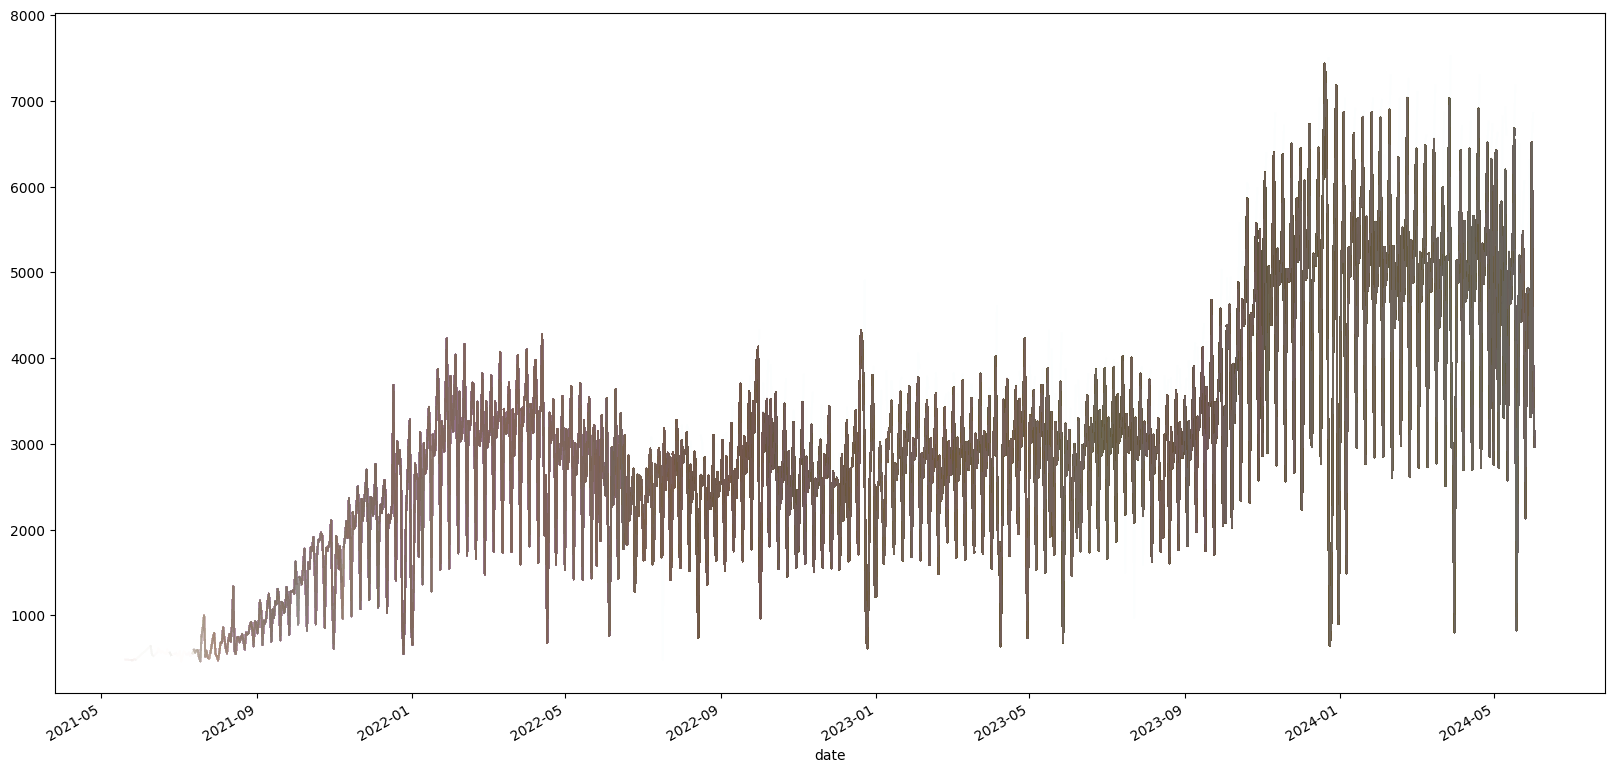

In [24]:
# Observe overlapping patterns
fig, ax = plt.subplots(1,1,figsize = (20,10))
wh_m1_pivot.plot(alpha = 0.01, ax = ax)
ax.get_legend().remove()

plt.show();

In [25]:
# Observe seasonality of the products from Munich_1

wh_m1

unique_id       date warehouse  total_orders   sales  \
35186         4167 2024-05-22  Munich_1        4422.0   24.97   
35187         4167 2023-09-06  Munich_1        2944.0    9.47   
35188         4167 2023-01-31  Munich_1        2814.0   17.18   
35189         4167 2023-02-03  Munich_1        3773.0   32.76   
35190         4167 2023-04-08  Munich_1        1853.0   16.98   
...            ...        ...       ...           ...     ...   
4007239       2235 2023-06-27  Munich_1        2861.0   56.90   
4007240       2235 2023-07-30  Munich_1        2157.0   32.47   
4007241       2235 2023-08-06  Munich_1        1622.0   28.92   
4007242       2235 2023-07-10  Munich_1        3579.0  119.18   
4007243       2235 2023-07-02  Munich_1        1661.0   66.18   

         sell_price_main  availability  type_0_discount  type_1_discount  \
35186               2.05          1.00              0.0              0.0   
35187               2.05          1.00              0.0              0.0   
35188               2.05          1.00              0.0              0.0   
35189               2.05          1.00              0.0              0.0   
35190               2.05          1.00              0.0              0.0   
...                  ...           ...              ...              ...   
4007239             4.15          0.87              0.0              0.0   
4007240             4.15          1.00              0.0              0.0   
4007241             4.15          1.00              0.0              0.0   
4007242             4.15          1.00              0.0              0.0   
4007243             4.15          1.00              0.0              0.0   

         type_2_discount  type_3_discount  type_4_discount  type_5_discount  \
35186                0.0              0.0              0.0              0.0   
35187                0.0              0.0              0.0              0.0   
35188                0.0              0.0              0.0              0.0   
35189                0.0              0.0              0.0              0.0   
35190                0.0              0.0              0.0              0.0   
...                  ...              ...              ...              ...   
4007239              0.0              0.0              0.0              0.0   
4007240              0.0              0.0              0.0              0.0   
4007241              0.0              0.0              0.0              0.0   
4007242              0.0              0.0              0.0              0.0   
4007243              0.0              0.0              0.0              0.0   

         type_6_discount  
35186                0.0  
35187                0.0  
35188                0.0  
35189                0.0  
35190                0.0  
...                  ...  
4007239              0.0  
4007240              0.0  
4007241              0.0  
4007242              0.0  
4007243              0.0  

[259333 rows x 14 columns]

In [26]:
list(train.columns)

['unique_id',
 'date',
 'warehouse',
 'total_orders',
 'sales',
 'sell_price_main',
 'availability',
 'type_0_discount',
 'type_1_discount',
 'type_2_discount',
 'type_3_discount',
 'type_4_discount',
 'type_5_discount',
 'type_6_discount']

### Cleaning discount columns 

In [27]:
# Remove negative values and null values

discount_cols = ['type_0_discount',
                 'type_1_discount',
                 'type_2_discount',
                 'type_3_discount',
                 'type_4_discount',
                 'type_5_discount',
                 'type_6_discount']

max_values = train[discount_cols].max(axis=1).values[:, None]

# Use NumPy for faster comparison and assignment
train[discount_cols] = np.where(train[discount_cols].values == max_values, train[discount_cols], 0)
train[discount_cols].describe()

type_0_discount  type_1_discount  type_2_discount  type_3_discount  \
count     4.007419e+06     4.007419e+06     4.007419e+06     4.007419e+06   
mean      8.364300e-03     1.238528e-04     1.159763e-03     4.242282e-06   
std       4.858056e-02     5.138391e-03     1.878547e-02     7.844067e-04   
min       0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00   
25%       0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00   
50%       0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00   
75%       0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00   
max       9.916400e-01     5.000000e-01     7.637200e-01     2.506300e-01   

       type_4_discount  type_5_discount  type_6_discount  
count     4.007419e+06     4.007419e+06     4.007419e+06  
mean      5.555494e-03     3.949383e-04     1.028712e-02  
std       2.862823e-02     9.107486e-03     5.530414e-02  
min       0.000000e+00     0.000000e+00     0.000000e+00  
25%       0.000000e+00     0.000000e+00     0.000000e+00  
50%       0.000000e+00     0.000000e+00     0.000000e+00  
75%       0.000000e+00     0.000000e+00     0.000000e+00  
max       4.529000e-01     6.691400e-01     9.000500e-01

### Treatment of missing value

In [28]:
# As the number of missing values in "total_orders" column and "sales" column are the same, check for cases where just one of the column data is missing.
missing_dates = train.loc[train.total_orders.isna()]
missing_dates.loc[(missing_dates.total_orders.isna())^(missing_dates.sales.isna())]

Empty DataFrame
Columns: [unique_id, date, warehouse, total_orders, sales, sell_price_main, availability, type_0_discount, type_1_discount, type_2_discount, type_3_discount, type_4_discount, type_5_discount, type_6_discount]
Index: []

> In other words, values are missing from both columns

In [29]:
# Examine missing data
missing_dates.groupby(['warehouse','unique_id','date']).agg(count = ('unique_id','count'))

count
warehouse   unique_id date             
Frankfurt_1 612       2021-12-09      1
                      2021-12-10      1
            794       2021-12-09      1
                      2021-12-10      1
            1237      2021-12-09      1
                      2021-12-10      1
Munich_1    725       2021-06-26      1
                      2021-06-27      1
            885       2021-05-21      1
                      2021-05-22      1
                      2021-05-23      1
                      2021-05-24      1
            1689      2021-06-12      1
                      2021-06-13      1
            1776      2021-07-11      1
            2148      2021-05-21      1
                      2021-05-22      1
                      2021-05-23      1
                      2021-05-24      1
                      2021-05-29      1
                      2021-05-30      1
                      2021-05-31      1
            2424      2021-06-12      1
                      2021-06-13      1
                      2021-06-19      1
                      2021-06-20      1
                      2021-06-26      1
                      2021-06-27      1
                      2021-07-04      1
                      2021-07-11      1
            2809      2021-06-12      1
                      2021-06-13      1
                      2021-06-26      1
                      2021-06-27      1
            3178      2021-05-21      1
                      2021-05-22      1
                      2021-05-23      1
                      2021-05-24      1
                      2021-05-29      1
                      2021-05-30      1
                      2021-05-31      1
            3778      2021-05-21      1
                      2021-05-22      1
                      2021-05-23      1
                      2021-05-24      1
                      2021-05-29      1
                      2021-05-30      1
                      2021-05-31      1
            5152      2021-05-21      1
                      2021-05-22      1
                      2021-05-23      1
                      2021-05-24      1

> All of the missing values are from whether Munich or Frankfurt warehouse. Both Total orders and sales data are missing.

<AxesSubplot:xlabel='date'>

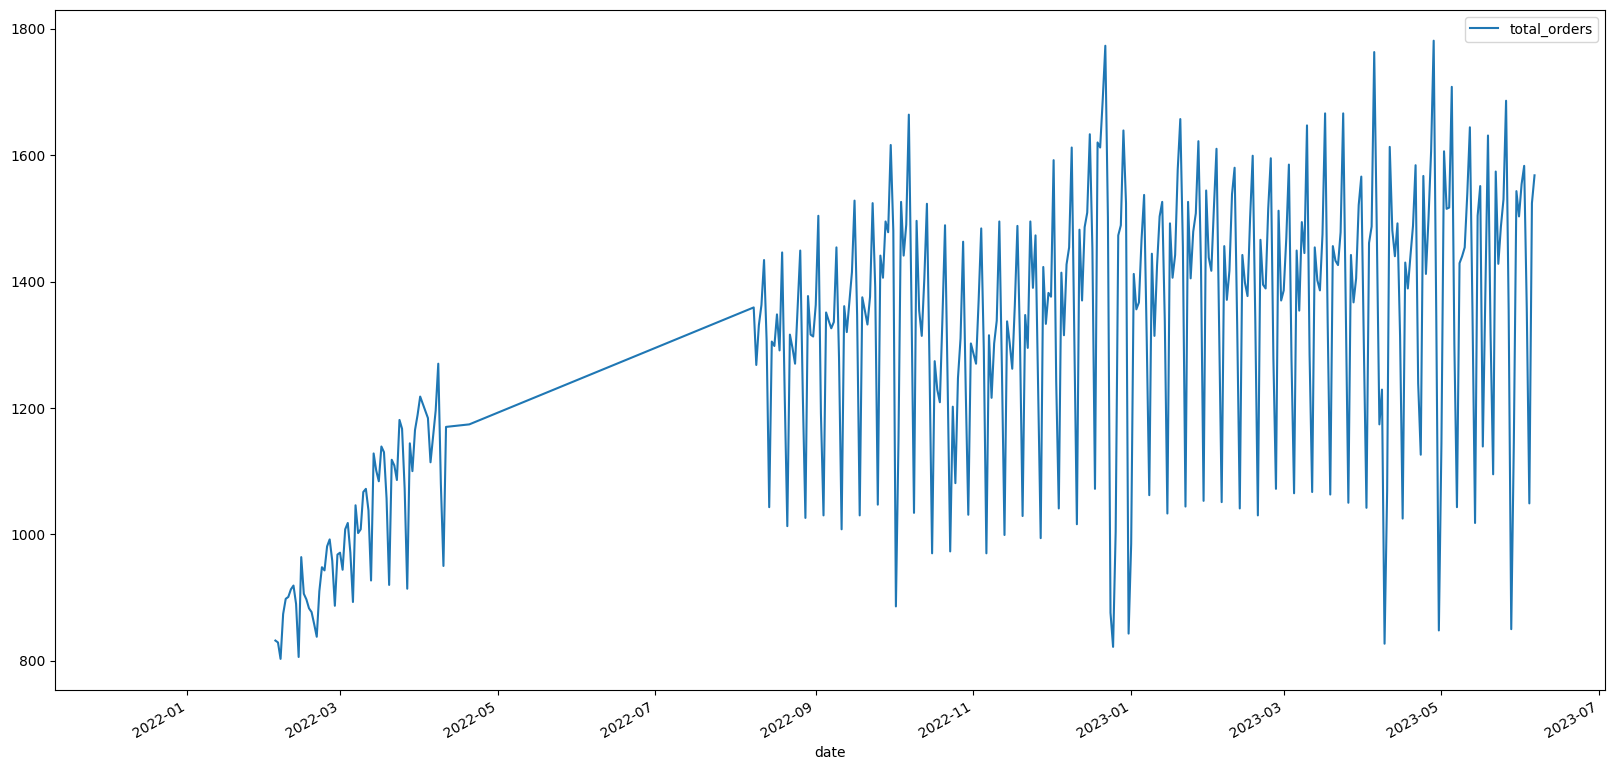

In [30]:
# Visualizing an example
fig, ax = plt.subplots(1,1,figsize= (20,10))
train.loc[train['unique_id']==612,['date','total_orders']].set_index('date').plot(ax = ax)

> Linearly interpolated values between April 2022 and August 2022 implies that there are missing dates. Missing date issue is obsevable with other products as well. 

In [31]:
train_full_date = pd.DataFrame(columns=train.columns)
train_full_date

Empty DataFrame
Columns: [unique_id, date, warehouse, total_orders, sales, sell_price_main, availability, type_0_discount, type_1_discount, type_2_discount, type_3_discount, type_4_discount, type_5_discount, type_6_discount]
Index: []

In [32]:
dfs = []

In [33]:
# Insert missing dates

for id in train['unique_id'].unique():
    filtered = train.loc[train['unique_id'] == id].set_index('date')
    date_index = pd.date_range(filtered.index.min(), filtered.index.max())
    filtered_complete = filtered.reindex(date_index)
    dfs.append(filtered_complete)
train_full_date = pd.concat(dfs)
train_full_date

unique_id   warehouse  total_orders  sales  sell_price_main  \
2020-08-01     4845.0  Budapest_1        3395.0  16.17           494.02   
2020-08-02     4845.0  Budapest_1        3424.0   3.85           494.02   
2020-08-03     4845.0  Budapest_1        3546.0  38.97           494.02   
2020-08-04     4845.0  Budapest_1        3510.0  23.81           494.02   
2020-08-05     4845.0  Budapest_1        3503.0  34.34           494.02   
...               ...         ...           ...    ...              ...   
2023-06-21     4941.0    Prague_1        9988.0  26.56            34.06   
2023-06-22     4941.0    Prague_1       10342.0  22.88            34.06   
2023-06-23     4941.0    Prague_1       10424.0  33.39            34.06   
2023-06-24     4941.0    Prague_1        8518.0  27.42            34.06   
2023-06-25     4941.0    Prague_1        9427.0  25.06            34.06   

            availability  type_0_discount  type_1_discount  type_2_discount  \
2020-08-01          1.00              0.0              0.0              0.0   
2020-08-02          1.00              0.0              0.0              0.0   
2020-08-03          1.00              0.0              0.0              0.0   
2020-08-04          1.00              0.0              0.0              0.0   
2020-08-05          1.00              0.0              0.0              0.0   
...                  ...              ...              ...              ...   
2023-06-21          1.00              0.0              0.0              0.0   
2023-06-22          1.00              0.0              0.0              0.0   
2023-06-23          1.00              0.0              0.0              0.0   
2023-06-24          1.00              0.0              0.0              0.0   
2023-06-25          0.39              0.0              0.0              0.0   

            type_3_discount  type_4_discount  type_5_discount  type_6_discount  
2020-08-01              0.0              0.0              0.0              0.0  
2020-08-02              0.0              0.0              0.0              0.0  
2020-08-03              0.0              0.0              0.0              0.0  
2020-08-04              0.0              0.0              0.0              0.0  
2020-08-05              0.0              0.0              0.0              0.0  
...                     ...              ...              ...              ...  
2023-06-21              0.0              0.0              0.0              0.0  
2023-06-22              0.0              0.0              0.0              0.0  
2023-06-23              0.0              0.0              0.0              0.0  
2023-06-24              0.0              0.0              0.0              0.0  
2023-06-25              0.0              0.0              0.0              0.0  

[4960929 rows x 13 columns]

In [34]:
train_full_date = train_full_date.reset_index().rename({'index':'date'}, axis = 1)

In [35]:
train_full_date.set_index('date')['unique_id']

date
2020-08-01    4845.0
2020-08-02    4845.0
2020-08-03    4845.0
2020-08-04    4845.0
2020-08-05    4845.0
               ...  
2023-06-21    4941.0
2023-06-22    4941.0
2023-06-23    4941.0
2023-06-24    4941.0
2023-06-25    4941.0
Name: unique_id, Length: 4960929, dtype: float64

In [36]:
pivot_table = train_full_date.pivot_table(index='unique_id', columns='date', values='sales')
pivot_table

date       2020-08-01  2020-08-02  2020-08-03  2020-08-04  2020-08-05  \
unique_id                                                               
0.0               NaN         NaN         NaN         NaN         NaN   
1.0               NaN         NaN         NaN         NaN         NaN   
2.0               NaN         NaN         NaN         NaN         NaN   
3.0               NaN         NaN         NaN         NaN         NaN   
5.0               NaN         NaN         NaN         NaN         NaN   
...               ...         ...         ...         ...         ...   
5427.0          32.06       34.73        23.6       40.62        28.4   
5428.0            NaN         NaN         NaN         NaN         NaN   
5429.0            NaN         NaN         NaN         NaN         NaN   
5430.0            NaN         NaN         NaN         NaN         NaN   
5431.0            NaN         NaN         NaN         NaN         NaN   

date       2020-08-06  2020-08-07  2020-08-08  2020-08-09  2020-08-10  ...  \
unique_id                                                              ...   
0.0               NaN         NaN         NaN         NaN         NaN  ...   
1.0               NaN         NaN         NaN         NaN         NaN  ...   
2.0               NaN         NaN         NaN         NaN         NaN  ...   
3.0               NaN         NaN         NaN         NaN         NaN  ...   
5.0               NaN         NaN         NaN         NaN         NaN  ...   
...               ...         ...         ...         ...         ...  ...   
5427.0          31.57       11.59       42.73       15.51       28.94  ...   
5428.0            NaN         NaN         NaN         NaN         NaN  ...   
5429.0            NaN         NaN         NaN         NaN         NaN  ...   
5430.0            NaN         NaN         NaN         NaN         NaN  ...   
5431.0            NaN         NaN         NaN         NaN         NaN  ...   

date       2024-05-24  2024-05-25  2024-05-26  2024-05-27  2024-05-28  \
unique_id                                                               
0.0               NaN         NaN         NaN         NaN         NaN   
1.0            101.62      139.62      161.81      164.51      222.28   
2.0            264.88      162.45      181.15      258.38      174.34   
3.0             86.82       90.19       77.81       95.66       87.28   
5.0               NaN         NaN         NaN         NaN         NaN   
...               ...         ...         ...         ...         ...   
5427.0          41.27       47.00       36.37       36.46       27.23   
5428.0          14.63        0.00        4.21       18.53       12.52   
5429.0          19.63        4.26        6.41       19.50        6.51   
5430.0           9.92        2.12        2.23        8.29        6.14   
5431.0           1.30        0.07        4.92       10.65        8.34   

date       2024-05-29  2024-05-30  2024-05-31  2024-06-01  2024-06-02  
unique_id                                                              
0.0               NaN         NaN         NaN         NaN         NaN  
1.0             93.87      141.62      236.32      143.30      206.75  
2.0            181.24      178.09      261.09      260.73      405.00  
3.0             67.45       94.32       95.15       80.96       78.60  
5.0               NaN         NaN         NaN         NaN         NaN  
...               ...         ...         ...         ...         ...  
5427.0          31.92       33.13       47.24       37.70       31.77  
5428.0          11.68       10.29       16.19       14.52       12.05  
5429.0          11.41       16.17       15.10        7.15       12.76  
5430.0           6.31       10.40        7.79        1.32        8.23  
5431.0           6.50       13.60        3.36       11.63        8.45  

[5390 rows x 1402 columns]

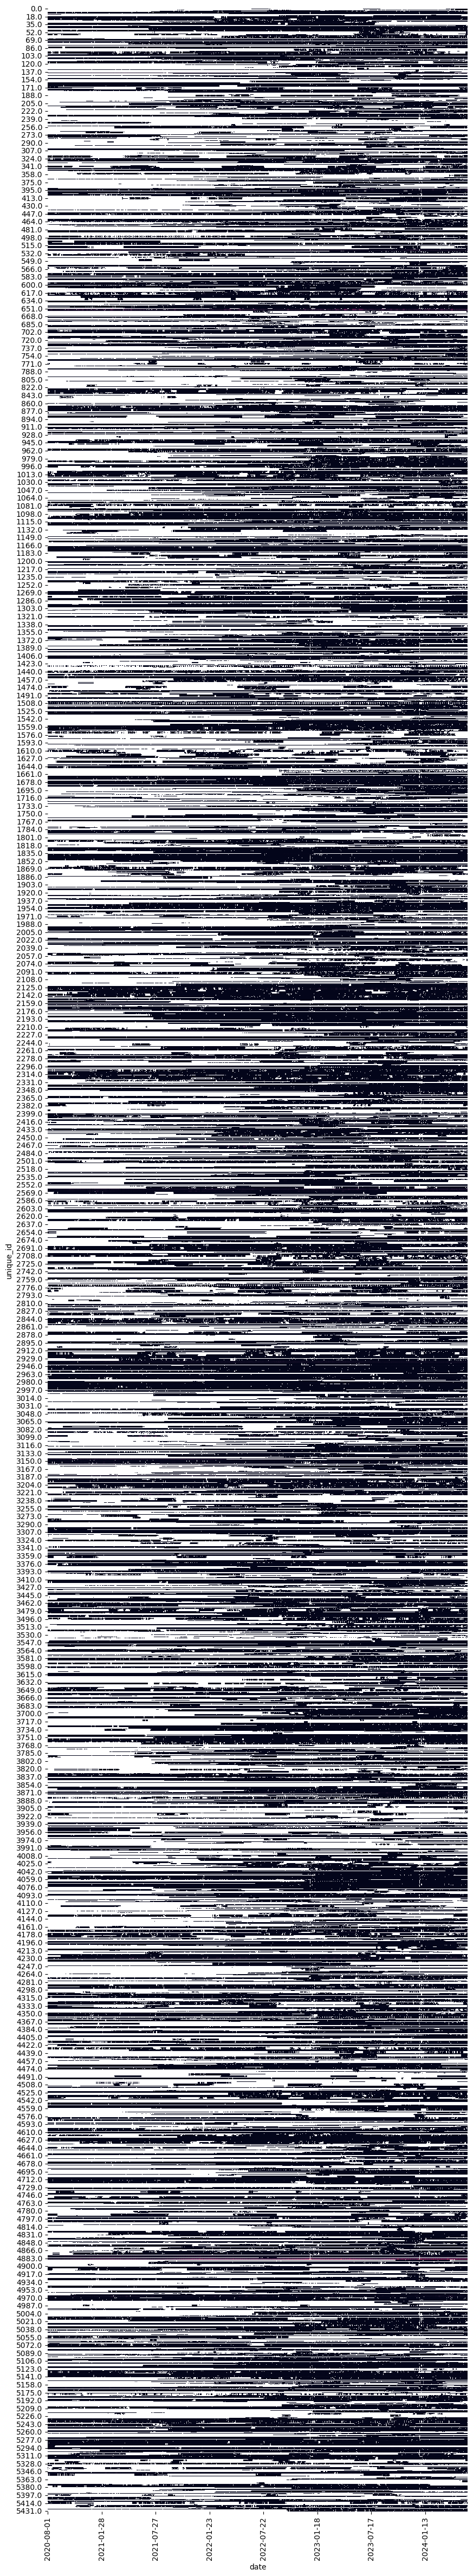

In [37]:
fig, ax = plt.subplots(1,1,figsize = (10,60))

sns.heatmap(pivot_table, ax = ax, cbar= False)

all_dates = pd.date_range(start=train_full_date['date'].min(), end=train_full_date['date'].max())

ax.set_xticks(range(0, len(all_dates), 180))
ax.set_xticklabels([all_dates[i].strftime('%Y-%m-%d') for i in range(0, len(all_dates), 180)])

plt.show();

## 1.3. `inventory` table

Columns
| Column name | Data type |Description |
|:--------:|:----:|:---------|
| unique_id | int64 | Inventory number attributed to the product in a given warehouse (Unique) |
| product_unique_id | int64 | Product id shared across the warehouses |
| name | object | Inventory name |
| L1_category_name_en | object | Internal category level 1 |
| L2_category_name_en | object | Internal category level 2 |
| L3_category_name_en | object | Internal category level 3 |
| L4_category_name_en | object | Internal category level 4 |
| warehouse | object | Name of the warehouse storing the product id |

In [38]:
inventory.head()

unique_id  product_unique_id        name  L1_category_name_en  \
0       5255               2583  Pastry_196               Bakery   
1       4948               2426     Herb_19  Fruit and vegetable   
2       2146               1079      Beet_2  Fruit and vegetable   
3        501                260  Chicken_13        Meat and fish   
4       4461               2197   Chicory_1  Fruit and vegetable   

         L2_category_name_en        L3_category_name_en  \
0               Bakery_L2_14               Bakery_L3_26   
1  Fruit and vegetable_L2_30  Fruit and vegetable_L3_86   
2   Fruit and vegetable_L2_3  Fruit and vegetable_L3_65   
3        Meat and fish_L2_13        Meat and fish_L3_27   
4  Fruit and vegetable_L2_17  Fruit and vegetable_L3_33   

         L4_category_name_en    warehouse  
0                Bakery_L4_1     Prague_3  
1   Fruit and vegetable_L4_1     Prague_3  
2  Fruit and vegetable_L4_34     Prague_1  
3         Meat and fish_L4_5     Prague_1  
4   Fruit and vegetable_L4_1  Frankfurt_1

In [39]:
inventory.shape

(5432, 8)

In [40]:
# Checking for null values
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5432 entries, 0 to 5431
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   unique_id            5432 non-null   int64 
 1   product_unique_id    5432 non-null   int64 
 2   name                 5432 non-null   object
 3   L1_category_name_en  5432 non-null   object
 4   L2_category_name_en  5432 non-null   object
 5   L3_category_name_en  5432 non-null   object
 6   L4_category_name_en  5432 non-null   object
 7   warehouse            5432 non-null   object
dtypes: int64(2), object(6)
memory usage: 339.6+ KB


In [41]:
# Renaming columns
columns_to_change = {'L1_category_name_en' : 'cat_l1',
                     'L2_category_name_en' : 'cat_l2',
                     'L3_category_name_en' : 'cat_l3',
                     'L4_category_name_en' : 'cat_l4'}
inventory.rename(columns_to_change, axis = 1, inplace = True)


In [42]:
# Reassigning values
inventory
inventory["cat_l2"] = inventory["cat_l2"].apply(lambda x : int(x.split('_')[2]))
inventory["cat_l3"] = inventory["cat_l3"].apply(lambda x : int(x.split('_')[2]))
inventory["cat_l4"] = inventory["cat_l4"].apply(lambda x : int(x.split('_')[2]))

In [43]:
inventory.cat_l1.unique()


array(['Bakery', 'Fruit and vegetable', 'Meat and fish'], dtype=object)

In [44]:
# Counting number of l2 category levels

inventory.groupby(['cat_l1']).agg(cat_l2_count=('cat_l2',lambda x : x.nunique()))

cat_l2_count
cat_l1                           
Bakery                         16
Fruit and vegetable            22
Meat and fish                   9

In [45]:
# Counting number of l3 category levels

inventory.groupby(['cat_l1']).agg(cat_l3_count=('cat_l3',lambda x : x.nunique()))

cat_l3_count
cat_l1                           
Bakery                         58
Fruit and vegetable            78
Meat and fish                  41

In [46]:
import plotly.express as px

fig = px.treemap(inventory,
                 path=["cat_l1", "cat_l2","cat_l3","cat_l4"],  # Hierarchy levels
                 values=[1]*inventory.shape[0],  # Using artificial values
                 color="cat_l1",  # Different colors per category
                 title="Product Category Hierarchy")

# Show the TreeMap
fig.show()

> Perhaps consider using cat_l2 or cat_l3 as 3 might be too granular

# 2. Merge data

In [47]:
sample = train_full_date[['unique_id','date','total_orders']].copy()
sample['lag'] = sample['total_orders'].shift(1)
sample['total_orders_pct'] = sample['total_orders']/sample['total_orders'].shift(1) - 1
sample.head(30)

unique_id       date  total_orders     lag  total_orders_pct
0      4845.0 2020-08-01        3395.0     NaN               NaN
1      4845.0 2020-08-02        3424.0  3395.0          0.008542
2      4845.0 2020-08-03        3546.0  3424.0          0.035631
3      4845.0 2020-08-04        3510.0  3546.0         -0.010152
4      4845.0 2020-08-05        3503.0  3510.0         -0.001994
5      4845.0 2020-08-06        3571.0  3503.0          0.019412
6      4845.0 2020-08-07        3589.0  3571.0          0.005041
7      4845.0 2020-08-08        3466.0  3589.0         -0.034271
8      4845.0 2020-08-09        3470.0  3466.0          0.001154
9      4845.0 2020-08-10        3625.0  3470.0          0.044669
10     4845.0 2020-08-11        3532.0  3625.0         -0.025655
11     4845.0 2020-08-12        3612.0  3532.0          0.022650
12     4845.0 2020-08-13        3617.0  3612.0          0.001384
13        NaN 2020-08-14           NaN  3617.0               NaN
14        NaN 2020-08-15           NaN     NaN               NaN
15        NaN 2020-08-16           NaN     NaN               NaN
16        NaN 2020-08-17           NaN     NaN               NaN
17        NaN 2020-08-18           NaN     NaN               NaN
18     4845.0 2020-08-19        3438.0     NaN               NaN
19     4845.0 2020-08-20        3270.0  3438.0         -0.048866
20     4845.0 2020-08-21        3462.0  3270.0          0.058716
21     4845.0 2020-08-22        3454.0  3462.0         -0.002311
22     4845.0 2020-08-23        3513.0  3454.0          0.017082
23     4845.0 2020-08-24        3574.0  3513.0          0.017364
24     4845.0 2020-08-25        3551.0  3574.0         -0.006435
25        NaN 2020-08-26           NaN  3551.0               NaN
26     4845.0 2020-08-27        3668.0     NaN               NaN
27     4845.0 2020-08-28        3685.0  3668.0          0.004635
28     4845.0 2020-08-29        3610.0  3685.0         -0.020353
29     4845.0 2020-08-30        3619.0  3610.0          0.002493

In [48]:
train_full_date['total_orders_pct'] = train_full_date['total_orders']/train_full_date['total_orders'].shift(1) - 1
train_full_date['sales_pct'] = train_full_date['sales']/train_full_date['sales'].shift(1) - 1
train_full_date

date  unique_id   warehouse  total_orders  sales  \
0       2020-08-01     4845.0  Budapest_1        3395.0  16.17   
1       2020-08-02     4845.0  Budapest_1        3424.0   3.85   
2       2020-08-03     4845.0  Budapest_1        3546.0  38.97   
3       2020-08-04     4845.0  Budapest_1        3510.0  23.81   
4       2020-08-05     4845.0  Budapest_1        3503.0  34.34   
...            ...        ...         ...           ...    ...   
4960924 2023-06-21     4941.0    Prague_1        9988.0  26.56   
4960925 2023-06-22     4941.0    Prague_1       10342.0  22.88   
4960926 2023-06-23     4941.0    Prague_1       10424.0  33.39   
4960927 2023-06-24     4941.0    Prague_1        8518.0  27.42   
4960928 2023-06-25     4941.0    Prague_1        9427.0  25.06   

         sell_price_main  availability  type_0_discount  type_1_discount  \
0                 494.02          1.00              0.0              0.0   
1                 494.02          1.00              0.0              0.0   
2                 494.02          1.00              0.0              0.0   
3                 494.02          1.00              0.0              0.0   
4                 494.02          1.00              0.0              0.0   
...                  ...           ...              ...              ...   
4960924            34.06          1.00              0.0              0.0   
4960925            34.06          1.00              0.0              0.0   
4960926            34.06          1.00              0.0              0.0   
4960927            34.06          1.00              0.0              0.0   
4960928            34.06          0.39              0.0              0.0   

         type_2_discount  type_3_discount  type_4_discount  type_5_discount  \
0                    0.0              0.0              0.0              0.0   
1                    0.0              0.0              0.0              0.0   
2                    0.0              0.0              0.0              0.0   
3                    0.0              0.0              0.0              0.0   
4                    0.0              0.0              0.0              0.0   
...                  ...              ...              ...              ...   
4960924              0.0              0.0              0.0              0.0   
4960925              0.0              0.0              0.0              0.0   
4960926              0.0              0.0              0.0              0.0   
4960927              0.0              0.0              0.0              0.0   
4960928              0.0              0.0              0.0              0.0   

         type_6_discount  total_orders_pct  sales_pct  
0                    0.0               NaN        NaN  
1                    0.0          0.008542  -0.761905  
2                    0.0          0.035631   9.122078  
3                    0.0         -0.010152  -0.389017  
4                    0.0         -0.001994   0.442251  
...                  ...               ...        ...  
4960924              0.0          0.039010  -0.172586  
4960925              0.0          0.035443  -0.138554  
4960926              0.0          0.007929   0.459353  
4960927              0.0         -0.182847  -0.178796  
4960928              0.0          0.106715  -0.086069  

[4960929 rows x 16 columns]

In [49]:
# Removing rows with null values
train_filtered = train_full_date.replace([np.inf,-np.inf], np.nan).dropna()
train_filtered.head()

date  unique_id   warehouse  total_orders  sales  sell_price_main  \
1 2020-08-02     4845.0  Budapest_1        3424.0   3.85           494.02   
2 2020-08-03     4845.0  Budapest_1        3546.0  38.97           494.02   
3 2020-08-04     4845.0  Budapest_1        3510.0  23.81           494.02   
4 2020-08-05     4845.0  Budapest_1        3503.0  34.34           494.02   
5 2020-08-06     4845.0  Budapest_1        3571.0   0.00           494.02   

   availability  type_0_discount  type_1_discount  type_2_discount  \
1           1.0              0.0              0.0              0.0   
2           1.0              0.0              0.0              0.0   
3           1.0              0.0              0.0              0.0   
4           1.0              0.0              0.0              0.0   
5           1.0              0.0              0.0              0.0   

   type_3_discount  type_4_discount  type_5_discount  type_6_discount  \
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   
5              0.0              0.0              0.0              0.0   

   total_orders_pct  sales_pct  
1          0.008542  -0.761905  
2          0.035631   9.122078  
3         -0.010152  -0.389017  
4         -0.001994   0.442251  
5          0.019412  -1.000000

In [50]:
train_filtered.set_index(['date','warehouse'], inplace=True)
train_filtered = train_filtered.sort_index()
train_filtered

unique_id  total_orders   sales  sell_price_main  \
date       warehouse                                                     
2020-08-01 Brno_1        2706.0        4797.0   40.07            56.90   
           Brno_1        5033.0        4797.0   17.81            45.09   
           Brno_1        3285.0        4797.0   40.07            17.84   
           Brno_1        1807.0        4797.0   17.81            92.78   
           Brno_1        3200.0        4797.0  251.54            28.85   
...                         ...           ...     ...              ...   
2024-06-02 Prague_3       362.0        5177.0  128.58            61.90   
           Prague_3      3907.0        5177.0   69.37            93.18   
           Prague_3      1345.0        5392.0   86.98            14.49   
           Prague_3      4747.0        5177.0  389.12           275.44   
           Prague_3      5368.0        5177.0   48.22             7.38   

                      availability  type_0_discount  type_1_discount  \
date       warehouse                                                   
2020-08-01 Brno_1             1.00          0.00000              0.0   
           Brno_1             1.00          0.00000              0.0   
           Brno_1             1.00          0.00000              0.0   
           Brno_1             1.00          0.00000              0.0   
           Brno_1             1.00          0.00000              0.0   
...                            ...              ...              ...   
2024-06-02 Prague_3           0.34          0.00000              0.0   
           Prague_3           1.00          0.00000              0.0   
           Prague_3           0.84          0.00000              0.0   
           Prague_3           0.65          0.06972              0.0   
           Prague_3           1.00          0.00000              0.0   

                      type_2_discount  type_3_discount  type_4_discount  \
date       warehouse                                                      
2020-08-01 Brno_1             0.00000              0.0              0.0   
           Brno_1             0.00000              0.0              0.0   
           Brno_1             0.00000              0.0              0.0   
           Brno_1             0.00000              0.0              0.0   
           Brno_1             0.00000              0.0              0.0   
...                               ...              ...              ...   
2024-06-02 Prague_3           0.00000              0.0              0.0   
           Prague_3           0.00000              0.0              0.0   
           Prague_3           0.00000              0.0              0.0   
           Prague_3           0.00000              0.0              0.0   
           Prague_3           0.15056              0.0              0.0   

                      type_5_discount  type_6_discount  total_orders_pct  \
date       warehouse                                                       
2020-08-01 Brno_1                 0.0              0.0         -0.506837   
           Brno_1                 0.0              0.0         -0.166174   
           Brno_1                 0.0              0.0         -0.166174   
           Brno_1                 0.0              0.0          0.619514   
           Brno_1                 0.0              0.0         -0.407119   
...                               ...              ...               ...   
2024-06-02 Prague_3               0.0              0.0         -0.012023   
           Prague_3               0.0              0.0         -0.012023   
           Prague_3               0.0              0.0         -0.074017   
           Prague_3               0.0              0.0         -0.012023   
           Prague_3               0.0              0.0         -0.012023   

                      sales_pct  
date       warehouse             
2020-08-01 Brno_1     -0.859596  
           Brno_1      0.319259  
           Brno_1    

In [51]:
# Merging calendar table
train_filtered = train_filtered.merge(calendar, on=['date','warehouse'], how='left')
train_filtered.reset_index(inplace=True)

In [52]:
train_filtered = train_filtered.merge(inventory[['unique_id','cat_l1', 'cat_l2','cat_l3','cat_l4','warehouse']], on ='unique_id', how = 'left')
train_filtered.head()

index       date warehouse_x  unique_id  total_orders   sales  \
0      0 2020-08-01      Brno_1     2706.0        4797.0   40.07   
1      1 2020-08-01      Brno_1     5033.0        4797.0   17.81   
2      2 2020-08-01      Brno_1     3285.0        4797.0   40.07   
3      3 2020-08-01      Brno_1     1807.0        4797.0   17.81   
4      4 2020-08-01      Brno_1     3200.0        4797.0  251.54   

   sell_price_main  availability  type_0_discount  type_1_discount  ...  \
0            56.90           1.0              0.0              0.0  ...   
1            45.09           1.0              0.0              0.0  ...   
2            17.84           1.0              0.0              0.0  ...   
3            92.78           1.0              0.0              0.0  ...   
4            28.85           1.0              0.0              0.0  ...   

    doy_cos   dow_sin   dow_cos  holiday_cat  consecutive_holidays  \
0 -0.856551 -0.974928 -0.222521          NaN                     0   
1 -0.856551 -0.974928 -0.222521          NaN                     0   
2 -0.856551 -0.974928 -0.222521          NaN                     0   
3 -0.856551 -0.974928 -0.222521          NaN                     0   
4 -0.856551 -0.974928 -0.222521          NaN                     0   

                cat_l1  cat_l2 cat_l3  cat_l4  warehouse_y  
0  Fruit and vegetable       3     18       1       Brno_1  
1  Fruit and vegetable       1     39      26       Brno_1  
2  Fruit and vegetable       1     53       1       Brno_1  
3  Fruit and vegetable       1     21       1       Brno_1  
4  Fruit and vegetable      11     19       1       Brno_1  

[5 rows x 36 columns]

In [53]:
train_filtered.shape

(3874741, 36)

In [54]:
# Check for different warehouse values in train and calendar tables

train_filtered.loc[train_filtered.warehouse_x != train_filtered.warehouse_y]

Empty DataFrame
Columns: [index, date, warehouse_x, unique_id, total_orders, sales, sell_price_main, availability, type_0_discount, type_1_discount, type_2_discount, type_3_discount, type_4_discount, type_5_discount, type_6_discount, total_orders_pct, sales_pct, holiday_name, holiday, shops_closed, winter_school_holidays, school_holidays, dow, weekend, doy, doy_sin, doy_cos, dow_sin, dow_cos, holiday_cat, consecutive_holidays, cat_l1, cat_l2, cat_l3, cat_l4, warehouse_y]
Index: []

[0 rows x 36 columns]

In [55]:
# As warehouse_x and warehouse_y are same, drop a column and rename remaining
train_filtered.drop(columns = 'warehouse_y', inplace = True)
train_filtered.rename({'warehouse_x' : 'warehouse'}, axis = 1, inplace = True)

In [56]:
# Drop irrelevant columns
train_filtered.drop(columns = ['index','winter_school_holidays','holiday_name','dow','doy','cat_l3','cat_l4'], inplace = True)
train_filtered.columns

Index(['date', 'warehouse', 'unique_id', 'total_orders', 'sales',
       'sell_price_main', 'availability', 'type_0_discount', 'type_1_discount',
       'type_2_discount', 'type_3_discount', 'type_4_discount',
       'type_5_discount', 'type_6_discount', 'total_orders_pct', 'sales_pct',
       'holiday', 'shops_closed', 'school_holidays', 'weekend', 'doy_sin',
       'doy_cos', 'dow_sin', 'dow_cos', 'holiday_cat', 'consecutive_holidays',
       'cat_l1', 'cat_l2'],
      dtype='object')

In [57]:
# Compressing data format

# float64 to float32
float_cols = train_filtered.select_dtypes('float64').columns
train_filtered.loc[:,float_cols] = train_filtered[float_cols].astype('float32')

# int64 to int32
int_cols = train_filtered.select_dtypes('int64').columns
train_filtered.loc[:,int_cols] = train_filtered[int_cols].astype('int32')

In [58]:
train_filtered

date warehouse  unique_id  total_orders       sales  \
0       2020-08-01    Brno_1     2706.0        4797.0   40.070000   
1       2020-08-01    Brno_1     5033.0        4797.0   17.809999   
2       2020-08-01    Brno_1     3285.0        4797.0   40.070000   
3       2020-08-01    Brno_1     1807.0        4797.0   17.809999   
4       2020-08-01    Brno_1     3200.0        4797.0  251.539993   
...            ...       ...        ...           ...         ...   
3874736 2024-06-02  Prague_3      362.0        5177.0  128.580002   
3874737 2024-06-02  Prague_3     3907.0        5177.0   69.370003   
3874738 2024-06-02  Prague_3     1345.0        5392.0   86.980003   
3874739 2024-06-02  Prague_3     4747.0        5177.0  389.119995   
3874740 2024-06-02  Prague_3     5368.0        5177.0   48.220001   

         sell_price_main  availability  type_0_discount  type_1_discount  \
0              56.900002          1.00          0.00000              0.0   
1              45.090000          1.00          0.00000              0.0   
2              17.840000          1.00          0.00000              0.0   
3              92.779999          1.00          0.00000              0.0   
4              28.850000          1.00          0.00000              0.0   
...                  ...           ...              ...              ...   
3874736        61.900002          0.34          0.00000              0.0   
3874737        93.180000          1.00          0.00000              0.0   
3874738        14.490000          0.84          0.00000              0.0   
3874739       275.440002          0.65          0.06972              0.0   
3874740         7.380000          1.00          0.00000              0.0   

         type_2_discount  ...  school_holidays  weekend   doy_sin   doy_cos  \
0                0.00000  ...                0        1 -0.516062 -0.856551   
1                0.00000  ...                0        1 -0.516062 -0.856551   
2                0.00000  ...                0        1 -0.516062 -0.856551   
3                0.00000  ...                0        1 -0.516062 -0.856551   
4                0.00000  ...                0        1 -0.516062 -0.856551   
...                  ...  ...              ...      ...       ...       ...   
3874736          0.00000  ...                0        1  0.471160 -0.882048   
3874737          0.00000  ...                0        1  0.471160 -0.882048   
3874738          0.00000  ...                0        1  0.471160 -0.882048   
3874739          0.00000  ...                0        1  0.471160 -0.882048   
3874740          0.15056  ...                0        1  0.471160 -0.882048   

          dow_sin   dow_cos  holiday_cat  consecutive_holidays  \
0       -0.974928 -0.222521          NaN                     0   
1       -0.974928 -0.222521          NaN                     0   
2       -0.974928 -0.222521          NaN                     0   
3       -0.974928 -0.222521          NaN                     0   
4       -0.974928 -0.222521          NaN                     0   
...           ...       ...          ...                   ...   
3874736 -0.781832  0.623490          NaN                     0   
3874737 -0.781832  0.623490          NaN                     0   
3874738 -0.781832  0.623490          NaN                     0   
3874739 -0.781832  0.623490          NaN                     0   
3874740 -0.781832  0.623490          NaN                     0   

                      cat_l1  cat_l2  
0        Fruit and vegetable       3  
1        Fruit and vegetable       1  
2        Fruit and vegetable       1  
3        Fruit and vegetable       1  
4        Fruit and vegetable      11  
...                      ...     ...  
3874736  Fruit and vegetable       3  
3874737  Fruit and vegetable       3  
3874738               Bakery      14  
3874739  Fruit and vegetable       1  
3874740               Bakery       7  

[3874741 rows x 28 columns]

In [59]:
list(train_filtered.select_dtypes('object').columns)

['warehouse', 'holiday_cat', 'cat_l1']

In [61]:
from sklearn.preprocessing import OneHotEncoder
train_filtered['cat_l2'] = train_filtered['cat_l2'].astype('object')




object_cols = list(train_filtered.select_dtypes('object').columns)

train_filtered = pd.concat([train_filtered, pd.get_dummies(train_filtered[object_cols], drop_first=True)], axis=1)
train_filtered = train_filtered.drop(columns=object_cols)
train_filtered

/home/kwonowk/.pyenv/versions/lewagon/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



date  unique_id  total_orders       sales  sell_price_main  \
0       2020-08-01     2706.0        4797.0   40.070000        56.900002   
1       2020-08-01     5033.0        4797.0   17.809999        45.090000   
2       2020-08-01     3285.0        4797.0   40.070000        17.840000   
3       2020-08-01     1807.0        4797.0   17.809999        92.779999   
4       2020-08-01     3200.0        4797.0  251.539993        28.850000   
...            ...        ...           ...         ...              ...   
3874736 2024-06-02      362.0        5177.0  128.580002        61.900002   
3874737 2024-06-02     3907.0        5177.0   69.370003        93.180000   
3874738 2024-06-02     1345.0        5392.0   86.980003        14.490000   
3874739 2024-06-02     4747.0        5177.0  389.119995       275.440002   
3874740 2024-06-02     5368.0        5177.0   48.220001         7.380000   

         availability  type_0_discount  type_1_discount  type_2_discount  \
0                1.00          0.00000              0.0          0.00000   
1                1.00          0.00000              0.0          0.00000   
2                1.00          0.00000              0.0          0.00000   
3                1.00          0.00000              0.0          0.00000   
4                1.00          0.00000              0.0          0.00000   
...               ...              ...              ...              ...   
3874736          0.34          0.00000              0.0          0.00000   
3874737          1.00          0.00000              0.0          0.00000   
3874738          0.84          0.00000              0.0          0.00000   
3874739          0.65          0.06972              0.0          0.00000   
3874740          1.00          0.00000              0.0          0.15056   

         type_3_discount  ...  cat_l2_36  cat_l2_37  cat_l2_38  cat_l2_39  \
0                    0.0  ...          0          0          0          0   
1                    0.0  ...          0          0          0          0   
2                    0.0  ...          0          0          0          0   
3                    0.0  ...          0          0          0          0   
4                    0.0  ...          0          0          0          0   
...                  ...  ...        ...        ...        ...        ...   
3874736              0.0  ...          0          0          0          0   
3874737              0.0  ...          0          0          0          0   
3874738              0.0  ...          0          0          0          0   
3874739              0.0  ...          0          0          0          0   
3874740              0.0  ...          0          0          0          0   

         cat_l2_40  cat_l2_41  cat_l2_42  cat_l2_43  cat_l2_44  cat_l2_45  
0                0          0          0          0          0          0  
1                0          0          0          0          0          0  
2                0          0          0          0          0          0  
3                0          0          0          0          0          0  
4                0          0          0          0          0          0  
...            ...        ...        ...        ...        ...        ...  
3874736          0          0          0          0          0          0  
3874737          0          0          0          0          0          0  
3874738          0          0          0          0          0          0  
3874739          0          0          0          0          0          0  
3874740          0          0          0          0          0          0  

[3874741 rows x 78 columns]

In [62]:
train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3874741 entries, 0 to 3874740
Data columns (total 78 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   date                        datetime64[ns]
 1   unique_id                   float32       
 2   total_orders                float32       
 3   sales                       float32       
 4   sell_price_main             float32       
 5   availability                float32       
 6   type_0_discount             float32       
 7   type_1_discount             float32       
 8   type_2_discount             float32       
 9   type_3_discount             float32       
 10  type_4_discount             float32       
 11  type_5_discount             float32       
 12  type_6_discount             float32       
 13  total_orders_pct            float32       
 14  sales_pct                   float32       
 15  holiday                     int32         
 16  shops_closed      

# Preparing for training

In [64]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
#from catboost import CatBoostRegressor, Pool

X = train_filtered.drop(columns=["date", "sales_pct","sales","total_orders"])
y = train_filtered["sales_pct"]

tscv = TimeSeriesSplit(n_splits=5)

xgb_models = []
xgb_errors = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5, verbosity = 2
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, preds)
    xgb_errors.append(rmse)
    xgb_models.append(model)

print("XGBoost RMSE Scores:", xgb_errors)
print("Mean RMSE:", np.mean(xgb_errors))

[17:07:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:07:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:07:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:07:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:07:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:07:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:07:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:07:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:07:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

In [ ]:
Make custom weighted mean average

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assume we have product features like category, price, etc.
df_cluster = train_filtered.select_dtypes(['number']).drop(columns=['unique_id','total_orders','sales','sell_price_main'])

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Apply K-Means
kmeans = KMeans(n_clusters=7, random_state=42)
train_filtered['cluster'] = kmeans.fit_predict(df_scaled)

print(train_filtered[['unique_id','warehouse', 'cat_l1','cluster']])

         unique_id warehouse               cat_l1  cluster
0           2706.0    Brno_1  Fruit and vegetable        4
1           5033.0    Brno_1  Fruit and vegetable        4
2           3285.0    Brno_1  Fruit and vegetable        4
3           1807.0    Brno_1  Fruit and vegetable        4
4           3200.0    Brno_1  Fruit and vegetable        4
...            ...       ...                  ...      ...
3874736      362.0  Prague_3  Fruit and vegetable        4
3874737     3907.0  Prague_3  Fruit and vegetable        4
3874738     1345.0  Prague_3               Bakery        4
3874739     4747.0  Prague_3  Fruit and vegetable        4
3874740     5368.0  Prague_3               Bakery        4

[3874741 rows x 4 columns]


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Assume we have product features like category, price, etc.
X = train_filtered.select_dtypes(['number']).drop(columns=['unique_id','total_orders','sales','sell_price_main'])

hc = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5)  # Auto-detect clusters
train_filtered['cluster'] = hc.fit_predict(X)

# Plot dendrogram to visualize hierarchy
linkage_matrix = linkage(X, method='ward')
dendrogram(linkage_matrix)

MemoryError: Unable to allocate 54.6 TiB for an array with shape (7506806971170,) and data type float64

In [ ]:
train_filtered.warehouse.nunique()

7

In [104]:
train_filtered.groupby('cluster').mean()

unique_id  total_orders       sales  sell_price_main  availability  \
cluster                                                                         
0        3109.267947   6621.772258  128.228209        82.476469      0.889490   
1        2671.572704   6601.292392  136.633734       182.012234      0.938055   
2        2682.119671   6016.079402  119.455319       170.897162      0.923729   
3        2730.705280   5081.663558   93.864374       178.714349      0.933349   
4        2706.684581   5614.772463  105.403806       186.746176      0.934994   
5        3014.886010   6041.122394   41.502348       222.393922      0.959636   
6        2696.969218   5984.424114  117.652714       174.027163      0.933541   

         type_0_discount  type_1_discount  type_2_discount  type_3_discount  \
cluster                                                                       
0               0.000052         0.000000         0.000010     0.000000e+00   
1               0.009188         0.000275         0.001968     1.310648e-08   
2               0.009294         0.000144         0.001332     4.316913e-08   
3               0.008259         0.000068         0.001076     2.757537e-06   
4               0.008499         0.000129         0.001214     2.009357e-06   
5               0.005850         0.000038         0.000438     3.279074e-05   
6               0.009926         0.000026         0.000807     0.000000e+00   

         type_4_discount  ...  shops_closed  school_holidays   weekend  \
cluster                   ...                                            
0               0.151934  ...      0.000114         0.001727  0.279434   
1               0.000015  ...      0.000000         0.012001  0.000010   
2               0.000015  ...      0.000000         0.006662  0.000539   
3               0.003808  ...      0.550988         0.038150  0.372369   
4               0.000009  ...      0.000000         0.010033  0.999887   
5               0.000002  ...      0.000000         0.007953  0.100757   
6               0.000009  ...      0.000000         0.001813  0.000083   

          doy_sin   doy_cos   dow_sin   dow_cos  consecutive_holidays  \
cluster                                                                 
0        0.031735  0.043622  0.011586 -0.010921              0.013847   
1        0.658629  0.012565  0.322204 -0.679781              0.000000   
2        0.005369  0.038031  0.401620  0.805783              0.000000   
3        0.225349  0.083347 -0.183206  0.097546              2.324328   
4       -0.006274  0.021216 -0.881435  0.186754              0.000000   
5        0.027873  0.041652  0.252959 -0.050312              0.000000   
6       -0.652489  0.061784  0.320539 -0.677764              0.000000   

            cat_l2      cat_l3  
cluster                         
0        11.369705   73.088643  
1         6.590666   48.814693  
2         6.462518   48.981647  
3         9.168122   56.585317  
4         8.337686   53.912262  
5        26.518191  104.916991  
6         6.517588   49.056640  

[7 rows x 25 columns]

In [ ]:
import ace_tools as tools
tools.display_dataframe_to_user(name="K-Means Cluster Summary", dataframe=cluster_summary)

In [52]:
# Drop irrelevant columns

# Convert columns to minimum types

# Shorten discount columns

# Multicolinearity of total_orderd & sales

# Do we need availability?

# Baseline

.drop((columns=['holiday_name',''])

      Clustering

SyntaxError: invalid syntax (2825950811.py, line 15)

In [75]:
train_filtered.loc[train_filtered.warehouse_x != train_filtered.warehouse_y]

Empty DataFrame
Columns: [date, warehouse_x, unique_id, total_orders, sales, sell_price_main, availability, type_0_discount, type_1_discount, type_2_discount, type_3_discount, type_4_discount, type_5_discount, type_6_discount, holiday_name, holiday, shops_closed, winter_school_holidays, school_holidays, dow, weekend, doy, category, Count, cat_l1, cat_l2, cat_l3, cat_l4, warehouse_y]
Index: []

[0 rows x 29 columns]

### Solution

In [ ]:
import pandas as pd

solution = pd.read_csv('data/solution.csv')
solution

id  sales_hat
0      1226_2024-06-03          0
1      1226_2024-06-11          0
2      1226_2024-06-13          0
3      1226_2024-06-15          0
4      1226_2024-06-09          0
...                ...        ...
47016  4572_2024-06-03          0
47017  3735_2024-06-04          0
47018  3735_2024-06-03          0
47019  2129_2024-06-03          0
47020  3030_2024-06-03          0

[47021 rows x 2 columns]

In [ ]:
solution['id_num'] = solution.id.apply(lambda x:x.split('_')[0])
solution

id  sales_hat id_num
0      1226_2024-06-03          0   1226
1      1226_2024-06-11          0   1226
2      1226_2024-06-13          0   1226
3      1226_2024-06-15          0   1226
4      1226_2024-06-09          0   1226
...                ...        ...    ...
47016  4572_2024-06-03          0   4572
47017  3735_2024-06-04          0   3735
47018  3735_2024-06-03          0   3735
47019  2129_2024-06-03          0   2129
47020  3030_2024-06-03          0   3030

[47021 rows x 3 columns]

In [ ]:
solution.id_num.nunique()

3625

In [ ]:
solution.id_num.value_counts()

1226    14
760     14
587     14
3272    14
4345    14
        ..
1022     1
368      1
3944     1
1021     1
3030     1
Name: id_num, Length: 3625, dtype: int64

In [ ]:
train_complete.loc[train_complete.unique_id == 760].isnull().sum()

date               0
unique_id          0
warehouse          0
total_orders       0
sales              0
sell_price_main    0
availability       0
type_0_discount    0
type_1_discount    0
type_2_discount    0
type_3_discount    0
type_4_discount    0
type_5_discount    0
type_6_discount    0
dtype: int64